# ETL Workflow for Forest Cover Change Analysis in the Congo Basin.

In [1]:
import os
import shutil
from datetime import datetime
import rasterio
import pystac
from pystac_client import Client
import geopandas as gpd
from shapely.geometry import box, Polygon, shape
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt 
import zarr
import dask
import dask.distributed
from dask.distributed import Client
import dask.array as da
from dask.diagnostics import ProgressBar

In [2]:
# Better visualization
plt.style.use('ggplot')

In [4]:
client = Client('127.0.0.1:8787')

{'tcp://127.0.0.1:51823': 1,
 'tcp://127.0.0.1:51824': 1,
 'tcp://127.0.0.1:51825': 1,
 'tcp://127.0.0.1:51827': 1}

In [3]:
DATA_DIR = 'kimongo_ndvi_archive'
ZARR_STORE = os.path.join(DATA_DIR, 'kimongo.zarr')

In [4]:
def log_progress(message): 
    timestamp_format = '%Y-%h-%d-%H:%M:%S' # Year-Monthname-Day-Hour-Minute-Second 
    now = datetime.now() # get current timestamp 
    timestamp = now.strftime(timestamp_format) 
    with open("./log/ndvi_log.txt","a") as f: 
        f.write(timestamp + ' : ' + message + '\n')

In [8]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
else :
    pass
    # shutil.rmtree(DATA_DIR)
    # os.makedirs(DATA_DIR)

In [15]:
# Recall current NDVI data from Zarr

log_progress(f"Loading Current_ndvi and Baseline_ndvi from zarr store")

current_ndvi = xr.open_zarr(ZARR_STORE, group="kimongo-etl-job", chunks='auto')
baseline_ndvi= xr.open_zarr(ZARR_STORE, group="kimongo-etl-job-baseline", chunks='auto')

In [6]:
# Compare NDVI
if current_ndvi is not None and baseline_ndvi is not None:
    log_progress(f"Processing... NDVI difference analysis")
    ndvi_difference = current_ndvi - baseline_ndvi

    display(ndvi_difference)

    # # Save NDVI difference to Zarr if needed
    # group = f'kimongo-etl-job-difference'
    # ndvi_difference.to_zarr(ZARR_STORE, mode='w', group=group)

    log_progress("NDVI Difference saved to Zarr store.")
   
else:
    log_progress(f"Error processing NDVI Change analysis")

<xarray.Dataset> Size: 9MB
Dimensions:                        (band: 2, x: 1250, y: 859)
Coordinates:
  * band                           (band) int32 8B 1 2
    spatial_ref                    int32 4B 0
  * x                              (x) float64 10kB 12.83 12.83 ... 13.08 13.08
  * y                              (y) float64 7kB -4.398 -4.398 ... -4.563
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float32 9MB dask.array<chunksize=(1, 859, 1250), meta=np.ndarray>

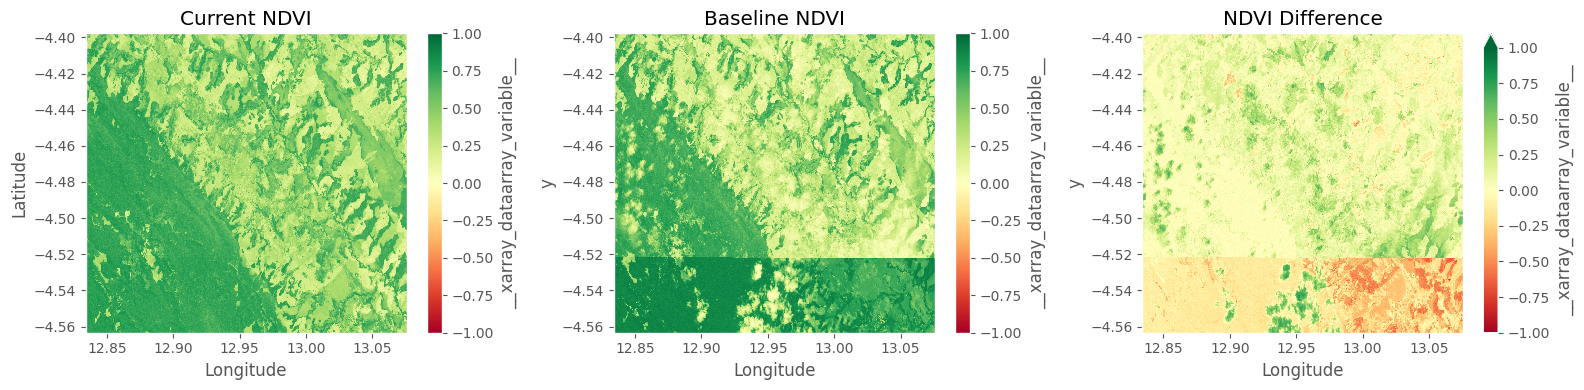

In [16]:
# Load the Zarr NDVI data stored in a raster dataset
log_progress('Loading NDVI Difference dataset from zarr store')

diff_ndvi = xr.open_zarr(ZARR_STORE, group="kimongo-etl-job-difference", chunks='auto')

log_progress('Loading complete')

# Access NDVI DataArray (assuming the NDVI is stored in the first band)
current_ndvi = current_ndvi['__xarray_dataarray_variable__'][0, :, :].squeeze()  # first band
baseline_ndvi = baseline_ndvi['__xarray_dataarray_variable__'][0, :, :].squeeze()  # first band
ndvi_difference = diff_ndvi['__xarray_dataarray_variable__'][0, :, :].squeeze()  # first band

log_progress('Creating NDVI Difference Maps')

# Create the NDVI Map
plt.figure(figsize=(16, 4)) 

# Plot Current NDVI
plt.subplot(1, 3, 1)
current_plot = current_ndvi.plot(cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Current NDVI')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Plot Baseline NDVI
plt.subplot(1, 3, 2)
baseline_plot = baseline_ndvi.plot(cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Baseline NDVI')
plt.xlabel("Longitude")

# Plot NDVI Difference
plt.subplot(1, 3, 3)
difference_plot = ndvi_difference.plot(cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('NDVI Difference')
plt.xlabel("Longitude")


plt.tight_layout()  # Adjust subplot spacing
plt.show()

log_progress('NDVI Differnce Map created.')

# client.close(timeout=60) 

log_progress('Dask client closed. ETL workflow complete.')


